# Tessellations network + Boeing network join

The Boeing network is a more simplified version of the OSMnx network. However, the Tessellations network covers zones that the Boeing network doesn't.

This notebook explores a way to join to __expand couverture in uncovered zones__ by joining parts of the OSMnx network to the Boeing network.

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [17]:
# Projection to be used whenever necessary
projected_crs = "EPSG:32618"

# Save plots in output > figures > volvo > networks_join
save_plots = True
savefig_dir = accesibilidad_urbana+"output/figures/volvo/networks_join/"

# Boeing input network
boeing_nodes_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp"
boeing_edges_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp"

# OSMnx input network
tess_nodes_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_nodes_f.gpkg" #From ntbk 06.
tess_edges_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_edges_f.gpkg" #From ntbk 06.

# Show dirs
print(boeing_nodes_dir)
print(boeing_edges_dir)
print(tess_nodes_dir)
print(tess_edges_dir)

../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp
../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp
../../../data/external/volvo/output_tessellations_network/moravia_LH_tessellations_nodes_f.gpkg
../../../data/external/volvo/output_tessellations_network/moravia_LH_tessellations_edges_f.gpkg


## Input data

### __Input data__ - Boeing network

In [8]:
# Load nodes data
boeing_nodes = gpd.read_file(boeing_nodes_dir)

# Set CRS
if boeing_nodes.crs != projected_crs:
    try:
        boeing_nodes = boeing_nodes.set_crs(projected_crs)
    except:
        boeing_nodes = boeing_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_nodes.columns))
boeing_nodes.reset_index(inplace=True)
boeing_nodes = boeing_nodes[['ID','geometry']]
boeing_nodes.rename(columns={'ID':'osmid'},inplace=True)

# Show
print(boeing_nodes.crs)
print(boeing_nodes.shape)
boeing_nodes.head(2)

['ID', 'coord_X', 'coord_Y', 'coord_Z', 'Type', 'geometry']
EPSG:32618
(743, 2)


,osmid,geometry
0,344191636,POINT (437449.345 692995.293)
1,344191639,POINT (437370.198 692566.062)


In [9]:
# Load edges data
boeing_edges = gpd.read_file(boeing_edges_dir)

# Set CRS
if boeing_edges.crs != projected_crs:
    try:
        boeing_edges = boeing_edges.set_crs(projected_crs)
    except:
        boeing_edges = boeing_edges.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_edges.columns))
boeing_edges.reset_index(inplace=True)
boeing_edges['key'] = 0
boeing_edges = boeing_edges[['from','to','key','geometry']]
boeing_edges.rename(columns={'from':'u','to':'v'},inplace=True)

# Show
print(boeing_edges.crs)
print(boeing_edges.shape)
boeing_edges.head(2)

['ID', 'from', 'to', 'length', 'grade_abs', 'speed', 'time', 'Type', 'geometry']
EPSG:32618
(1077, 4)


,u,v,key,geometry
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."
1,344191636,429632637,0,"LINESTRING (437449.345 692995.293, 437544.786 ..."


### __Input data__ - Tessellations network

In [13]:
# Load nodes data
tess_nodes = gpd.read_file(tess_nodes_dir)

# Set CRS
if tess_nodes.crs != projected_crs:
    try:
        tess_nodes = tess_nodes.set_crs(projected_crs)
    except:
        tess_nodes = tess_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(tess_nodes.columns))
tess_nodes.reset_index(inplace=True)
tess_nodes = tess_nodes[['osmid','geometry']]

# Show
print(tess_nodes.crs)
print(tess_nodes.shape)
tess_nodes.head(2)

['osmid', 'streets_count', 'geometry']
EPSG:32618
(978, 2)


,osmid,geometry
0,0,POINT (437387.239 692067.632)
1,1,POINT (437436.817 692056.015)


In [15]:
# Load edges data
tess_edges = gpd.read_file(tess_edges_dir)

# Set CRS
if tess_edges.crs != projected_crs:
    try:
        tess_edges = tess_edges.set_crs(projected_crs)
    except:
        tess_edges = tess_edges.to_crs(projected_crs)

# Filter and rename data
print(list(tess_edges.columns))
tess_edges.reset_index(inplace=True)
tess_edges = tess_edges[['u','v','key','geometry']]

# Show
print(tess_edges.crs)
print(tess_edges.shape)
tess_edges.head(2)

['u', 'v', 'key', 'geometry']
EPSG:32618
(1601, 4)


,u,v,key,geometry
0,0,1,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


### __Input data__ - Visualize

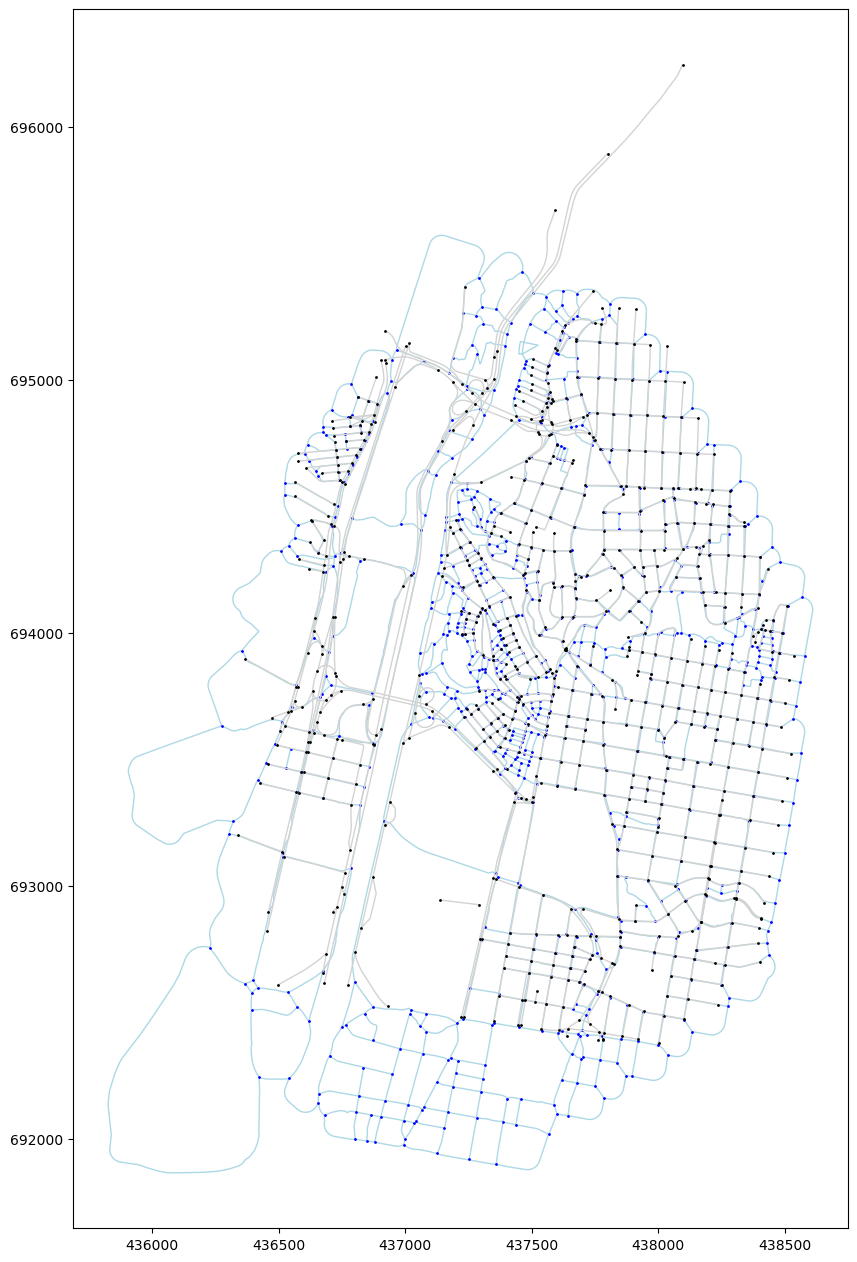

In [18]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "PartA_00_networks_visualization.svg")

## Step 1: Identify the parts of the Tessellations network that should be added to the Boeing network

###  __Step 1 - Plan A__ Explanation
#### Create a buffer around all Tess nodes. If the buffer touches the Boeing network, consider that part of the Tess network as already covered by the Boeing network. For the rest of the nodes, find the edges that connect to them and find the node that would be used to connect to the Boeing network (Nodes that are connected to the selected Tess network and whose buffer touches the Boeing network)

#### __Result:__ Worked well when joining OSMnx + Boeing network, but some lines were not considered. (e.g. a street whose nodes are located very close to the Boeing Network, but whose path [edge] crosses an uncovered zone). When trying to join Tessellations+Boeing several problems arised. --> __Plan B__ works by considering the representative_point() of complementary (Tessellation) edges as the point of interest to check if it is close enough to the base (Boeing) network [Instead of using the complementary (Tesellations) nodes].

### __Step 1 - Plan A__ Development

#### __1-A.1__ Create buffer around each node (Keeping osmid)

In [19]:
# Reset node's index
tess_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

# Save each node's reseted index in a column named 'index'
nodes_to_buffer = tess_nodes.copy()
nodes_to_buffer.reset_index(inplace=True) #--> Creates col 'index'

# Create a gdf containing the buffer around nodes
tess_nodes_buffer = nodes_to_buffer.buffer(10)
tess_nodes_buffer = gpd.GeoDataFrame(geometry=tess_nodes_buffer)
tess_nodes_buffer.reset_index(inplace=True) #--> Creates col 'index'

# Transfer data from nodes to its buffer using the index as merge col
nodes_to_buffer.drop(columns=['geometry'],inplace=True)
tess_nodes_buffer = pd.merge(tess_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using col 'index'
tess_nodes_buffer.drop(columns=['index'],inplace=True)

# Show
print(tess_nodes_buffer.shape)
tess_nodes_buffer.head(2)

(978, 2)


,geometry,osmid
0,"POLYGON ((437397.239 692067.632, 437397.191 69...",0
1,"POLYGON ((437446.817 692056.015, 437446.768 69...",1


<Axes: >

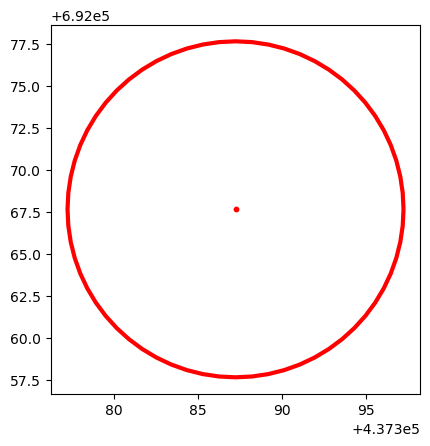

In [21]:
osmid_test = 0

node_test = tess_nodes.loc[tess_nodes.osmid==osmid_test]
buffer_test = tess_nodes_buffer.loc[tess_nodes_buffer.osmid==osmid_test]

# Plot
fig,ax = plt.subplots(1,1)

node_test.plot(ax=ax,zorder=1,color='red',markersize=10)
buffer_test.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

#### __1-A.2__ Find nodes whose buffer does not intersect with any part of the Boeing network

In [22]:
# Buffers that touch any Boeing edge
buffer_touch = tess_nodes_buffer.sjoin(boeing_edges)
osmid_touch_lst = list(buffer_touch.osmid.unique())

# Nodes that are not near any Boeing edge
tess_uncovered_nodes = tess_nodes.loc[~tess_nodes.osmid.isin(osmid_touch_lst)]

# Show
print(tess_uncovered_nodes.shape)
tess_uncovered_nodes.head(2)

(306, 2)


,osmid,geometry
0,0,POINT (437387.239 692067.632)
1,1,POINT (437436.817 692056.015)


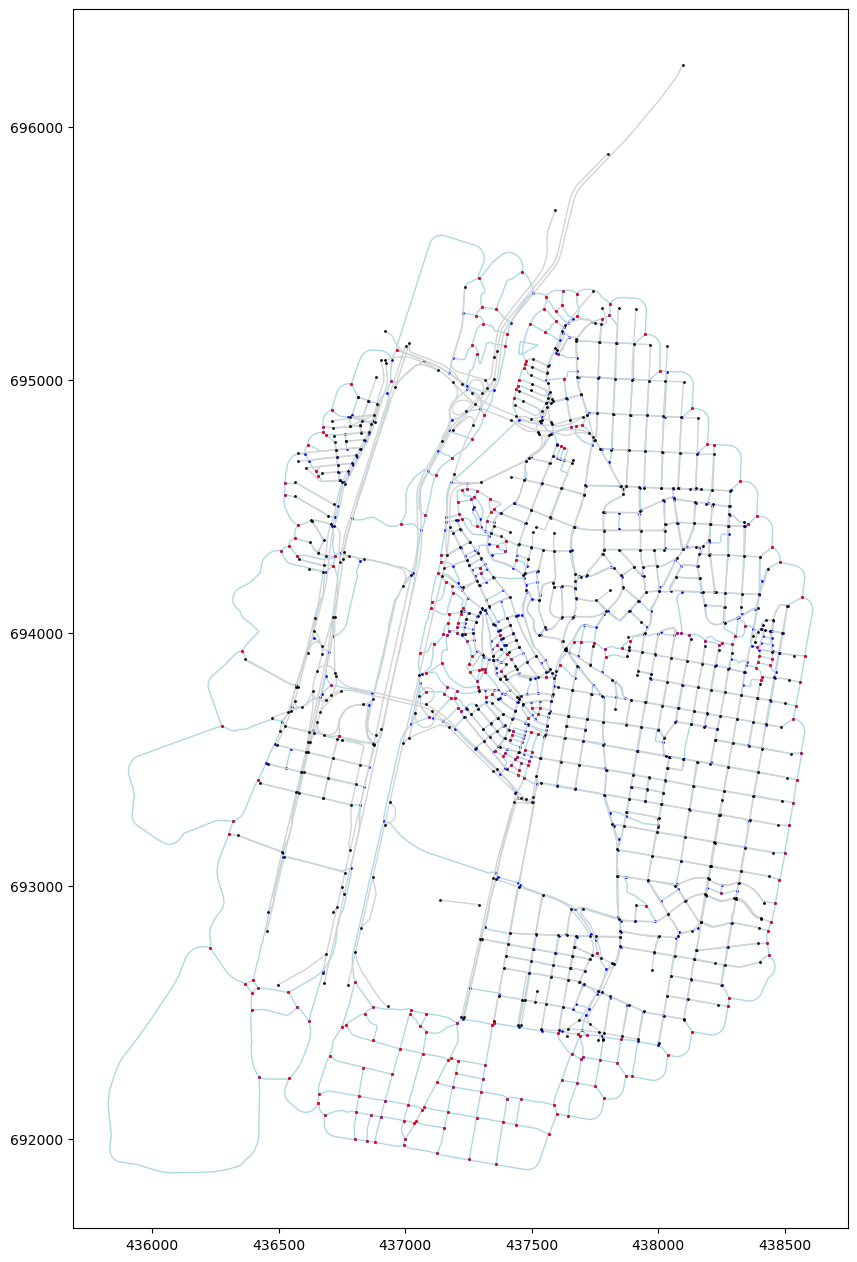

In [23]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

tess_uncovered_nodes.plot(ax=ax,zorder=4,color='red',markersize=1)
boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "PartA_01_uncovered_nodes.svg")

#### __1-A.3__ Select the edges that connect to the uncovered nodes

In [24]:
# List of unique osmids that are currently uncovered
tess_uncovered_osmid_lst = list(tess_uncovered_nodes.osmid.unique())
# Select any edge where its 'u' or 'v' is in tess_uncovered_osmid_lst
tess_uncovered_edges = tess_edges.loc[(tess_edges.u.isin(tess_uncovered_osmid_lst)) | (tess_edges.v.isin(tess_uncovered_osmid_lst))].copy()

# Show
print(tess_uncovered_edges.shape)
tess_uncovered_edges.head(2)

(628, 4)


,u,v,key,geometry
0,0,1,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


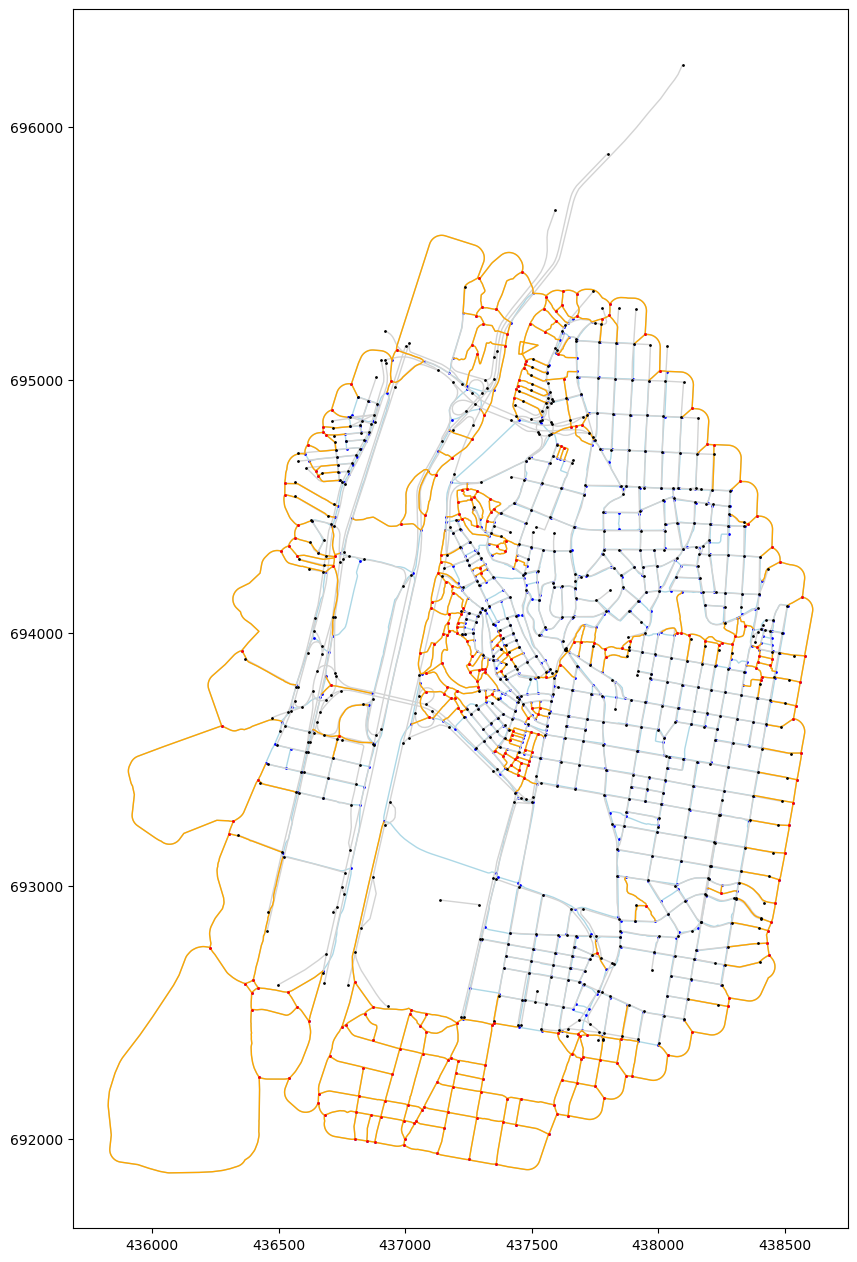

In [25]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

tess_uncovered_nodes.plot(ax=ax,zorder=5,color='red',markersize=1)
tess_uncovered_edges.plot(ax=ax,zorder=3,color='orange',linewidth=1)
boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "PartA_03_uncovered_edges.svg")

#### __1-A.4__ Find the nodes that would be used to connect the uncovered network to the Boeing network

In [26]:
# Find all non-duplicated (set) unique 'u's and 'v's in the tess_uncovered_edges gdf.
uncovered_vertexes = set(list(tess_uncovered_edges.u.unique()) + list(tess_uncovered_edges.v.unique()))
# From those vertexes, find those that do not form part of the uncovered network
contact_osmids = [osmid for osmid in uncovered_vertexes if osmid not in tess_uncovered_osmid_lst]
# Select nodes from those osmids
contact_nodes = tess_nodes.loc[tess_nodes.osmid.isin(contact_osmids)].copy()

# Show
print(contact_nodes.shape)
contact_nodes.head(2)

(243, 2)


,osmid,geometry
8,4,POINT (437921.235 692384.410)
9,5,POINT (438000.016 692369.895)


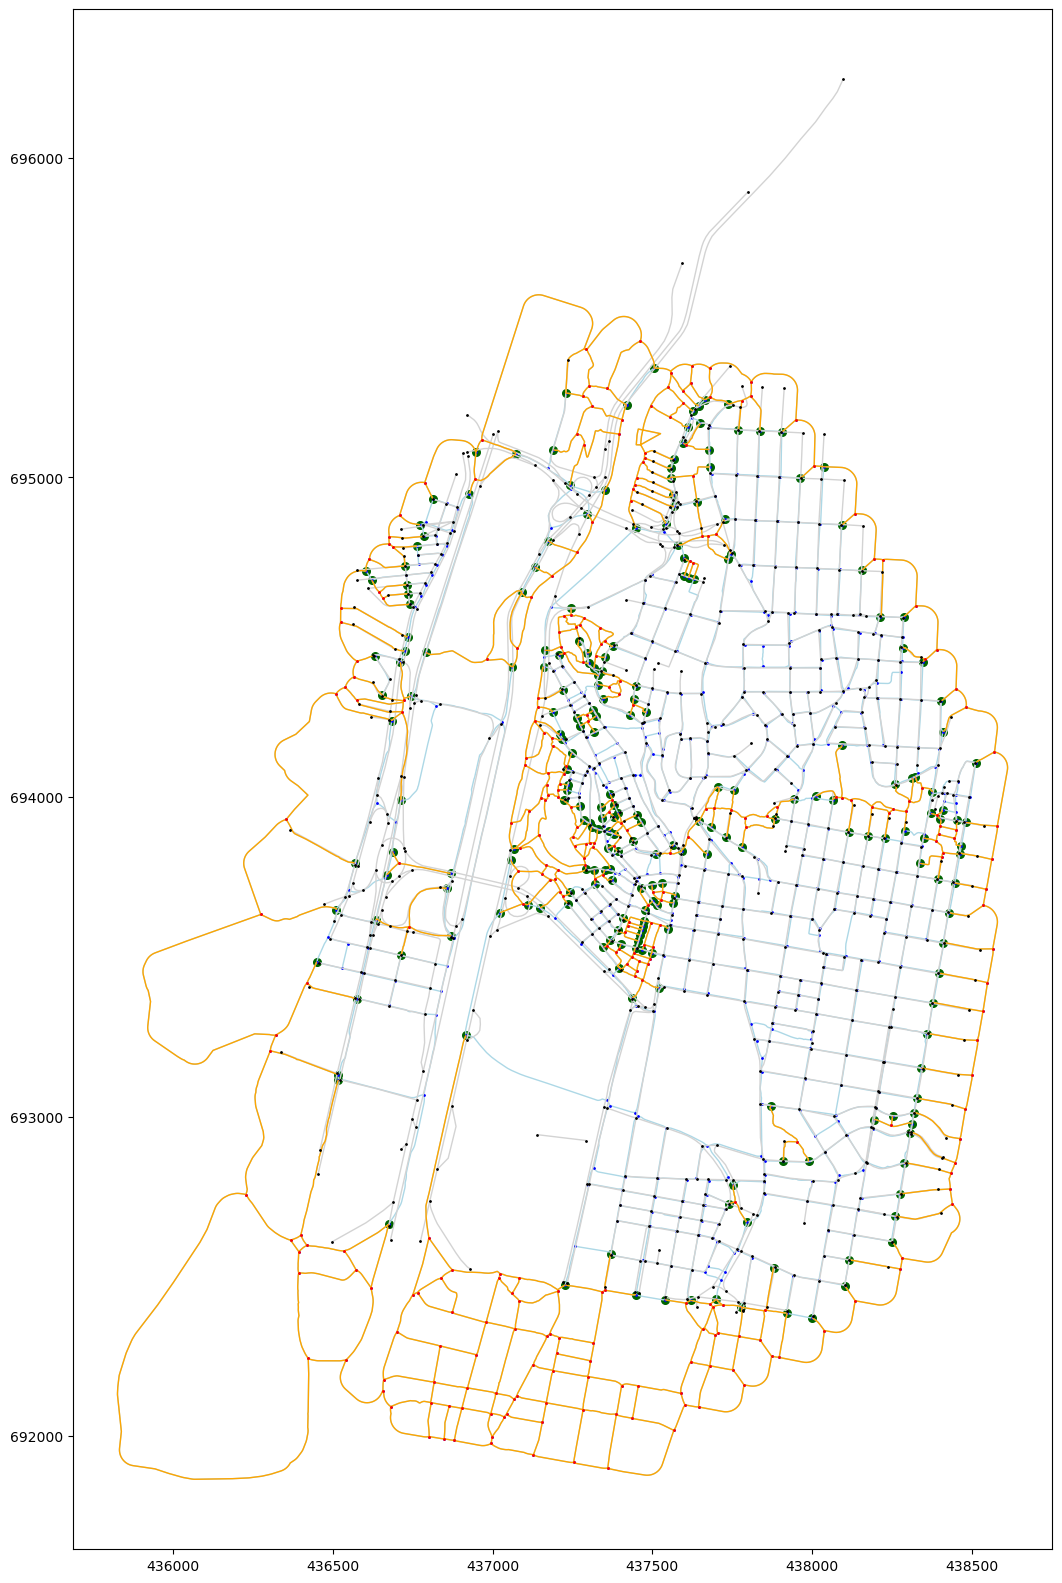

In [27]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(20,20))

tess_uncovered_nodes.plot(ax=ax,zorder=5,color='red',markersize=1)
tess_uncovered_edges.plot(ax=ax,zorder=3,color='orange',linewidth=1)
boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

contact_nodes.plot(ax=ax,zorder=-1,color='darkgreen',markersize=30)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "PartA_04_contact_nodes.svg")

### __Step 1 - Plan A__ Function

In [28]:
def identify_uncovered(base_edges, complementary_nodes, complementary_edges, uncovered_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) 
        where currently there's no coverture in a base network.
	Args:
		base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		uncovered_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {uncovered_dist} is created around all complementary_nodes. If the buffer touches the base_edges, the node
                                from that buffer is considered as already covered by the base network. If the buffer does not touches the base_edges,
                                the complementary node is considered a complementary_uncovered_node.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that 
                                                                are not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that 
                                                                are not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""
    # 1.0 --------------- Create buffer around complementary_nodes (keeping nodes ID)
    # ------------------- INPUT - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- 
    
    # Reset complementary node's index
    complementary_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary node's reseted index in a column named 'index'
    nodes_to_buffer = complementary_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Create a gdf containing the buffer around complementary nodes
    complementary_nodes_buffer = nodes_to_buffer.buffer(uncovered_dist)
    complementary_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_nodes_buffer)
    complementary_nodes_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Transfer data from complementary nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_nodes_buffer = pd.merge(complementary_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using col 'index'
    complementary_nodes_buffer.drop(columns=['index'],inplace=True)
    
    # 2.0 --------------- Find complementary nodes whose buffer does not intersect with any part of the base network
    # ------------------- INPUT - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = complementary_nodes_buffer.sjoin(base_edges)
    osmid_touch_lst = list(buffer_touch.osmid.unique())
    # Nodes that are not near any base edge
    complementary_uncovered_nodes = complementary_nodes.loc[~complementary_nodes.osmid.isin(osmid_touch_lst)].copy()

    # 3.0 --------------- Select the complementary edges that connect to the complementary uncovered nodes
    # ------------------- INPUT - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ COMPLEMENTARY EDGES
    
    # List of unique osmids that are currently uncovered
    complementary_uncovered_osmid_lst = list(complementary_uncovered_nodes.osmid.unique())
    # Select any edge where its 'u' or 'v' is in complementary_uncovered_osmid_lst
    complementary_uncovered_edges = complementary_edges.loc[(complementary_edges.u.isin(complementary_uncovered_osmid_lst)) | (complementary_edges.v.isin(complementary_uncovered_osmid_lst))].copy()

    # 4.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network
    
    # Find all non-duplicated (set) unique 'u's and 'v's in the complementary_uncovered_edges gdf
    uncovered_vertexes = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # From those vertexes, find those that do not form part of the uncovered network
    # (Meaning, discard the complementary_uncovered_osmid_lst. Those osmids are far from the base network. We need to know which ones are close, those will be our connecting points.)
    contact_osmids = [osmid for osmid in uncovered_vertexes if osmid not in complementary_uncovered_osmid_lst]
    # Select nodes from those osmids
    contact_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(contact_osmids)].copy()

    
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes

Join network using a uncovered distance of 5.
Join network using a uncovered distance of 10.
Join network using a uncovered distance of 15.


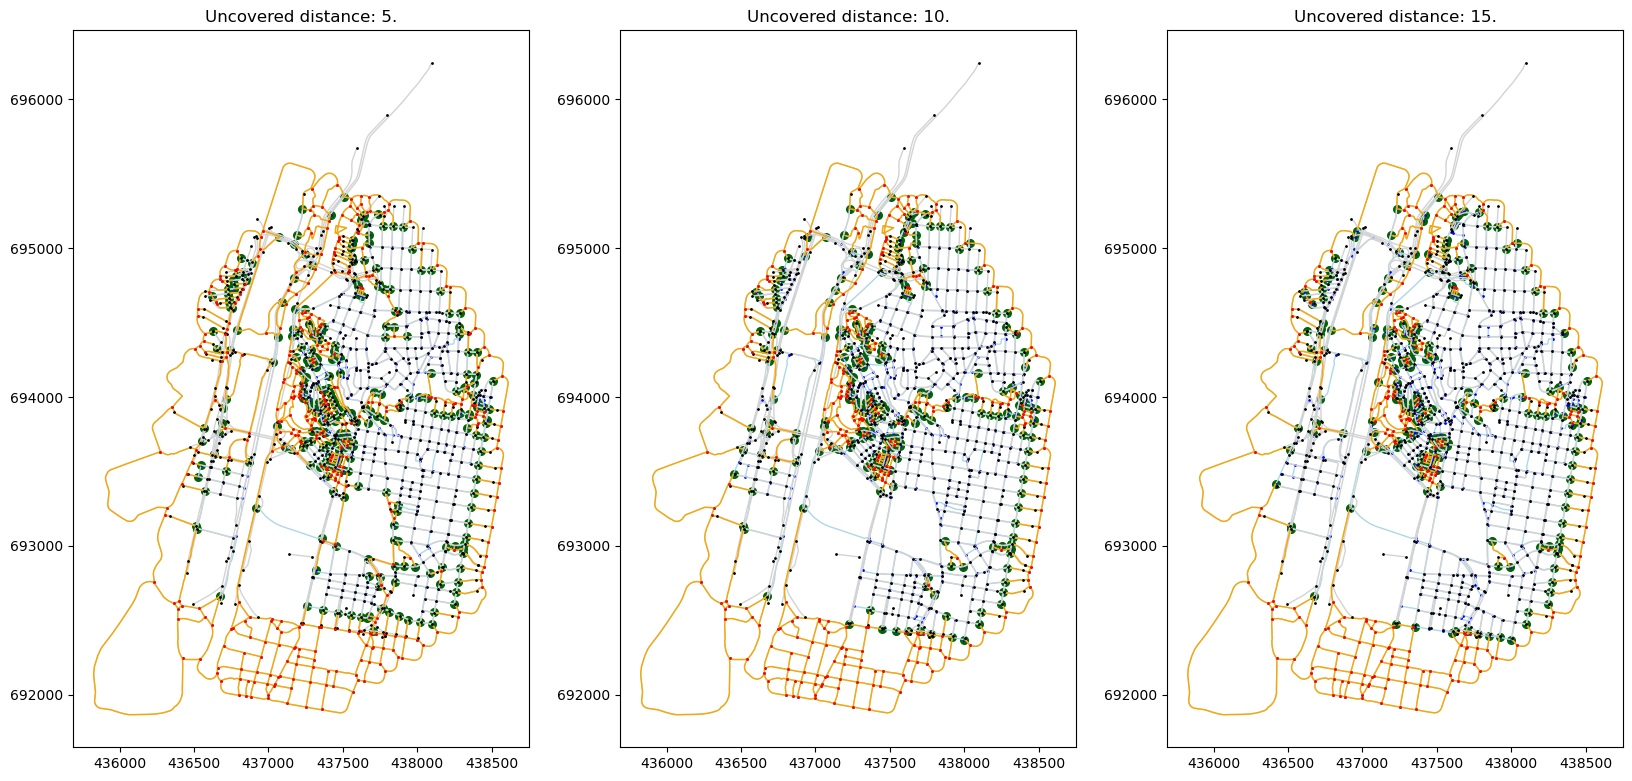

In [29]:
distances_test = [5,10,15]

fig,axs = plt.subplots(1,len(distances_test),figsize=(20,20))
i = 0

for distance in distances_test:
    # Identify join network
    print(f"Join network using a uncovered distance of {distance}.")
    complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes = identify_uncovered(base_edges = boeing_edges,
                                                                                                     complementary_nodes = tess_nodes,
                                                                                                     complementary_edges = tess_edges, 
                                                                                                     uncovered_dist = distance,
                                                                                                     projected_crs = projected_crs)

    # Plot
    complementary_uncovered_nodes.plot(ax=axs[i],zorder=5,color='red',markersize=1)
    complementary_uncovered_edges.plot(ax=axs[i],zorder=3,color='orange',linewidth=1)
    boeing_nodes.plot(ax=axs[i],zorder=3,color='black',markersize=1)
    boeing_edges.plot(ax=axs[i],zorder=2,color='lightgrey',linewidth=1)
    tess_nodes.plot(ax=axs[i],zorder=1,color='blue',markersize=1)
    tess_edges.plot(ax=axs[i],zorder=0,color='lightblue',linewidth=1)
    
    contact_nodes.plot(ax=axs[i],zorder=-1,color='darkgreen',markersize=30)

    # Format - Title
    axs[i].set_title(f"Uncovered distance: {distance}.")

    i+=1

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + f"PartA_{distances_test}.svg")

###  __Step 1 - Plan B__ Explanation

#### __Plan B__ works by considering the representative_point() of complementary (Tessellation) edges as the point of interest to check if it is close enough to the base (Boeing) network [Instead of using the complementary (Tesellations) nodes].

#### __Representative_point() test__

In [49]:
edges_test = tess_edges.loc[(tess_edges.u==0)].copy()
edges_test

,u,v,key,geometry
0,0,1,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
2,0,230,0,"LINESTRING (437387.239 692067.632, 437387.021 ..."
3,0,191,0,"LINESTRING (437387.239 692067.632, 437387.021 ..."


In [50]:
edges_test['representative_point'] = edges_test.representative_point()
representative_points_test = edges_test[['u','v','key','representative_point']].copy()
representative_points_test.rename(columns={'representative_point':'geometry'},inplace=True)
 
representative_points_test

,u,v,key,geometry
0,0,1,0,POINT (437411.553 692060.506)
1,0,3,0,POINT (437373.040 691984.151)
2,0,230,0,POINT (437396.146 692112.701)
3,0,191,0,POINT (437335.372 692075.471)


<Axes: >

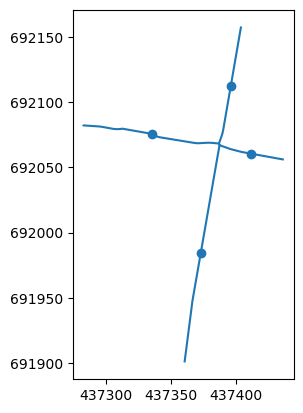

In [51]:
fig,ax=plt.subplots()
edges_test.plot(ax=ax)
representative_points_test.plot(ax=ax)

### __Step 1 - Plan B__ Function

In [67]:
def identify_uncovered(base_edges, complementary_nodes, complementary_edges, uncovered_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) where currently there's no coverture in a base network.
	Args:
		base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		uncovered_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {uncovered_dist} is created around all complementary_nodes. If the buffer touches the base_edges, the node
                                from that buffer is considered as already covered by the base network. If the buffer does not touches the base_edges,
                                the complementary node is considered a complementary_uncovered_node.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that 
                                                                are not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that 
                                                                are not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""

    # ------------------- INPUT - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- 

    
    # 1.0 --------------- Extract representative point for each complementary edge
    # ------------------- INPUT - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ COMPLEMENTARY EDGES

    # Create unique ID for each edge using u+v
    complementary_edges['u'] = complementary_edges['u'].astype('str')
    complementary_edges['v'] = complementary_edges['v'].astype('str')
    complementary_edges['edge_id'] = complementary_edges['u']+complementary_edges['v']
    # Return 'u' and 'v' to int
    complementary_edges['u'] = complementary_edges['u'].astype('int')
    complementary_edges['v'] = complementary_edges['v'].astype('int')
    # Find representative point
    complementary_edges['representative_point'] = complementary_edges.representative_point()
    # Assign representative point to its own gdf and drop representative_point from complementary_edges
    representative_points = complementary_edges[['edge_id','representative_point']].copy()
    representative_points.rename(columns={'representative_point':'geometry'},inplace=True)
    complementary_edges.drop(columns=['representative_point'],inplace=True)
    
    # 2.0 --------------- Create buffer around representative points (keeping u and v data)

    # Reset representative_points's index
    representative_points.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each representative_points's reseted index in a column named 'index'
    points_to_buffer = representative_points.copy()
    points_to_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Create a gdf containing the buffer around representative_points
    representative_points_buffer = points_to_buffer.buffer(uncovered_dist)
    representative_points_buffer = gpd.GeoDataFrame(geometry=representative_points_buffer)
    representative_points_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Transfer data from representative_points to it's buffer using the index as merge col
    points_to_buffer.drop(columns=['geometry'],inplace=True)
    representative_points_buffer = pd.merge(representative_points_buffer,points_to_buffer,on='index') #--> Merges using col 'index'
    representative_points_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del points_to_buffer
    
    # 3.0 --------------- Find representative_points whose buffer does not intersect with any part of the base network
    # ------------------- INPUT - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = representative_points_buffer.sjoin(base_edges)
    edge_id_touch_lst = list(buffer_touch.edge_id.unique())
    # Nodes that are not near any base edge
    complementary_uncovered_edges = complementary_edges.loc[~complementary_edges.edge_id.isin(edge_id_touch_lst)].copy()

    # 3.0 --------------- Select the complementary nodes that connect to the complementary_uncovered_edges
    
    # List of unique 'u's and 'v's that are currently uncovered
    complementary_uncovered_osmid_lst = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # Select any edge where its 'osmid' is in complementary_uncovered_osmid_lst
    complementary_uncovered_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(complementary_uncovered_osmid_lst)].copy()

    # 4.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network

    # 4.1 --- Create a buffer around all complementary_uncovered_nodes
    # Reset complementary_uncovered_nodes's index
    complementary_uncovered_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary_uncovered_nodes's reseted index in a column named 'index'
    nodes_to_buffer = complementary_uncovered_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Create a gdf containing the buffer around complementary_uncovered_nodes
    complementary_uncovered_nodes_buffer = nodes_to_buffer.buffer(uncovered_dist)
    complementary_uncovered_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_uncovered_nodes_buffer)
    complementary_uncovered_nodes_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Transfer data from complementary_uncovered_nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_uncovered_nodes_buffer = pd.merge(complementary_uncovered_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using col 'index'
    complementary_uncovered_nodes_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del nodes_to_buffer
    
    # 4.2 --- Find complementary_uncovered_nodes whose buffer DOES intersect with any part of the base network
    # Buffers that touch any base edge
    buffer_touch = complementary_uncovered_nodes_buffer.sjoin(base_edges)
    contact_osmids = list(buffer_touch.osmid.unique())
    # Nodes that are not near any base edge
    contact_nodes = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid.isin(contact_osmids)].copy()
    
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes

Join network using a uncovered distance of 5.
Join network using a uncovered distance of 10.
Join network using a uncovered distance of 15.


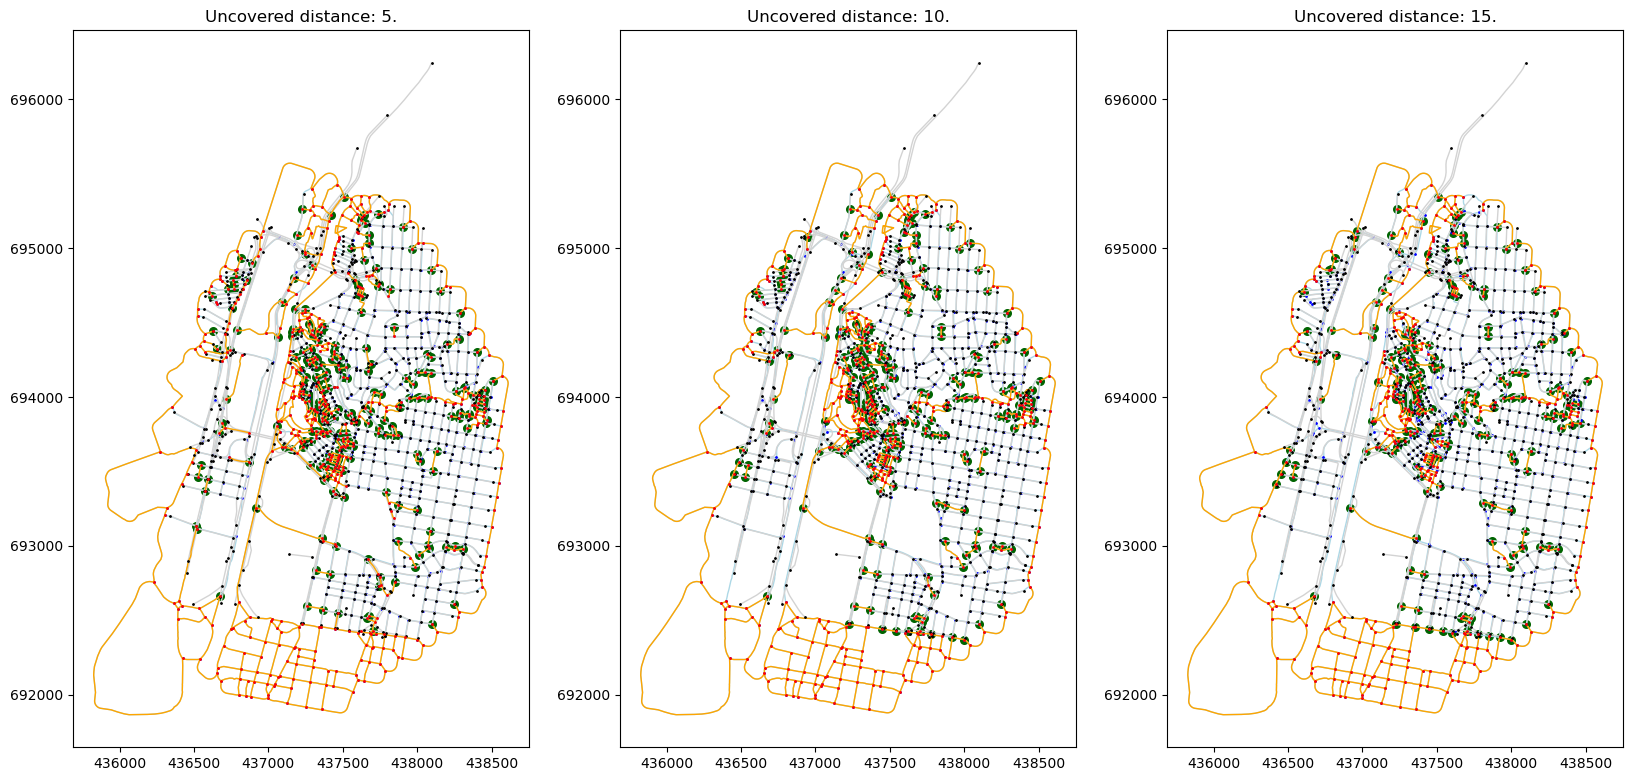

In [69]:
distances_test = [5,10,15]

fig,axs = plt.subplots(1,len(distances_test),figsize=(20,20))
i = 0

for distance in distances_test:
    # Identify join network
    print(f"Join network using a uncovered distance of {distance}.")
    complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes = identify_uncovered(base_edges = boeing_edges,
                                                                                                     complementary_nodes = tess_nodes,
                                                                                                     complementary_edges = tess_edges, 
                                                                                                     uncovered_dist = distance,
                                                                                                     projected_crs = projected_crs)

    # Plot
    complementary_uncovered_nodes.plot(ax=axs[i],zorder=5,color='red',markersize=1)
    complementary_uncovered_edges.plot(ax=axs[i],zorder=3,color='orange',linewidth=1)
    boeing_nodes.plot(ax=axs[i],zorder=3,color='black',markersize=1)
    boeing_edges.plot(ax=axs[i],zorder=2,color='lightgrey',linewidth=1)
    tess_nodes.plot(ax=axs[i],zorder=1,color='blue',markersize=1)
    tess_edges.plot(ax=axs[i],zorder=0,color='lightblue',linewidth=1)
    
    contact_nodes.plot(ax=axs[i],zorder=-1,color='darkgreen',markersize=30)

    # Format - Title
    axs[i].set_title(f"Uncovered distance: {distance}.")

    i+=1

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + f"PlanB_{distances_test}.svg")